In [1]:
import wandb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: martingratzer (martingratzer-organization). Use `wandb login --relogin` to force relogin


True

In [2]:
def gratzer_style_sns():
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2)
    sns.set_palette(["#004c76", "#e31837", "#ffa600", "#558a35","#f9691f","#c71770","#007274","#8d3d91","#474c91"])
    plt.rcParams['figure.figsize'] = (8, 5)
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['savefig.bbox'] = 'tight'
    
def gratzer_lighter_style_sns():
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2)
    sns.set_palette(["#76ceff", "#f391a0", "#ffd689", "#bbdda6","#fca97f","#f18abe","#88fdff","#d7a5d9","#a3a6d2"])
    plt.rcParams['figure.figsize'] = (8, 5)
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['savefig.bbox'] = 'tight'

<BarContainer object of 1 artists>

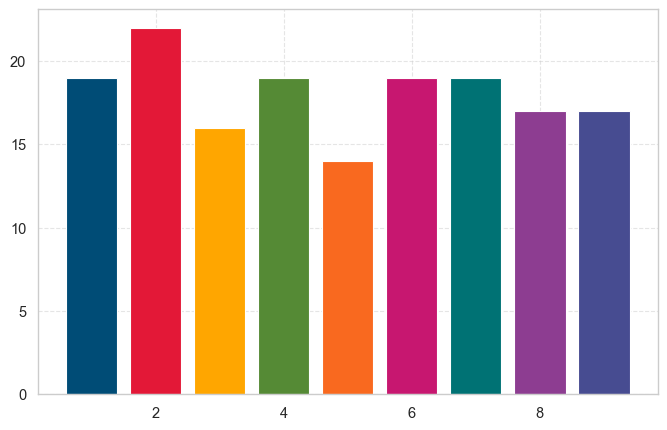

In [3]:
gratzer_style_sns()
plt.bar(1,np.random.binomial(25,0.7))
plt.bar(2,np.random.binomial(25,0.7))
plt.bar(3,np.random.binomial(25,0.7))
plt.bar(4,np.random.binomial(25,0.7))
plt.bar(5,np.random.binomial(25,0.7))
plt.bar(6,np.random.binomial(25,0.7))
plt.bar(7,np.random.binomial(25,0.7))
plt.bar(8,np.random.binomial(25,0.7))
plt.bar(9,np.random.binomial(25,0.7))

In [4]:
ENTITY = "martingratzer-organization"
PROJECTS = ["CIFAR-100-RD-Sigmoid-T4", "CIFAR-100-RD", "CIFAR-100-RD-NoAlpha"]

api = wandb.Api(timeout=150)

all_histories = []

for project in PROJECTS:
    runs = api.runs(f"{ENTITY}/{project}")  # Get all runs for the project
    
    for run in runs:
        history = run.history(keys=["eval_top1", "_step"], pandas=True)
        alpha = run.config.get("alpha", None)  # Use None if alpha is missing
        history["alpha"] = alpha  # Add alpha column
        history["project"] = project  # Add project column
        
        all_histories.append(history)

# Combine all runs into a single DataFrame
final_df = pd.concat(all_histories, ignore_index=True)

# Display the first few rows
print(final_df.head())

   _step  eval_top1  alpha                  project
0      0       2.32    7.5  CIFAR-100-RD-Sigmoid-T4
1      1       3.41    7.5  CIFAR-100-RD-Sigmoid-T4
2      2       4.46    7.5  CIFAR-100-RD-Sigmoid-T4
3      3       4.95    7.5  CIFAR-100-RD-Sigmoid-T4
4      4       6.01    7.5  CIFAR-100-RD-Sigmoid-T4


In [5]:
runs = api.runs(f"{ENTITY}/CIFAR-100")
all_histories = []
for run in runs:
    history = run.history(keys=["eval_top1", "_step"], pandas=True)
    name = run.config.get("wandb_name", None)
    history['name'] = name
    all_histories.append(history)

In [6]:
teacher_and_vanilla = pd.concat([all_histories[-1],all_histories[-3]], ignore_index=True)

In [7]:
runs = api.runs(f"{ENTITY}/CIFAR-100-RD-AdjustedLR")
all_histories = []
for run in runs:
    history = run.history(keys=["eval_top1", "_step"], pandas=True)
    alpha = run.config.get("alpha", None)
    no_alpha_adjustment = run.config.get("no_alpha_adjustment", None)
    history['alpha'] = alpha
    history['no_alpha_adjustment'] = no_alpha_adjustment
    all_histories.append(history)
    
adjusted_lr_test = pd.concat(all_histories, ignore_index=True)

In [8]:
alr_grouped = adjusted_lr_test.groupby(['_step', 'alpha', 'no_alpha_adjustment'])['eval_top1'].mean().reset_index()

In [9]:
alr_grouped['group'] = (alr_grouped['alpha'] == 5)*1 + (alr_grouped['no_alpha_adjustment'] == 0)*1
alr_grouped['group'] = alr_grouped['group'].map({0: 'Baseline', 1: 'Not Adjusted', 2: 'Adjusted'})

<Axes: xlabel='_step', ylabel='eval_top1'>

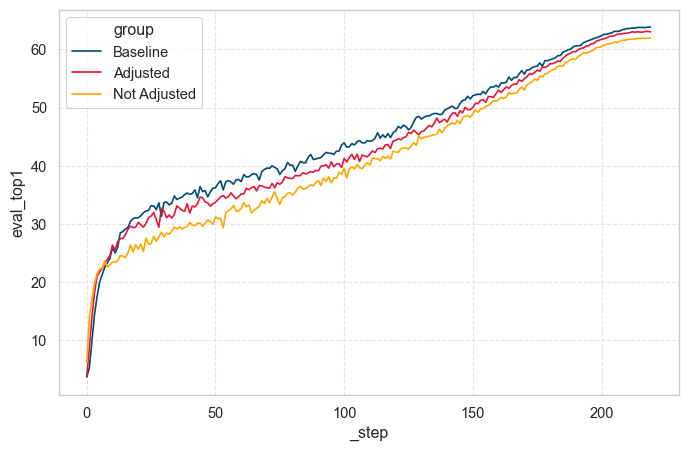

In [10]:
gratzer_style_sns()
sns.lineplot(data=alr_grouped,x='_step',y='eval_top1',hue='group')

In [11]:
pivoted = alr_grouped.pivot(index='_step', columns='group', values='eval_top1')

In [12]:
pivoted['Not Adjusted vs Baseline'] = pivoted['Not Adjusted'] - pivoted['Baseline']
pivoted['Adjusted vs Baseline'] = pivoted['Adjusted'] - pivoted['Baseline']
pivoted = pivoted.reset_index()

<Axes: >

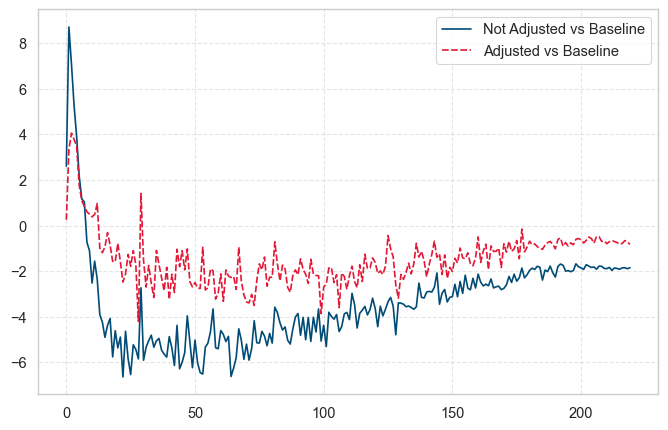

In [13]:
gratzer_style_sns()
sns.lineplot([pivoted['Not Adjusted vs Baseline'],pivoted['Adjusted vs Baseline']])

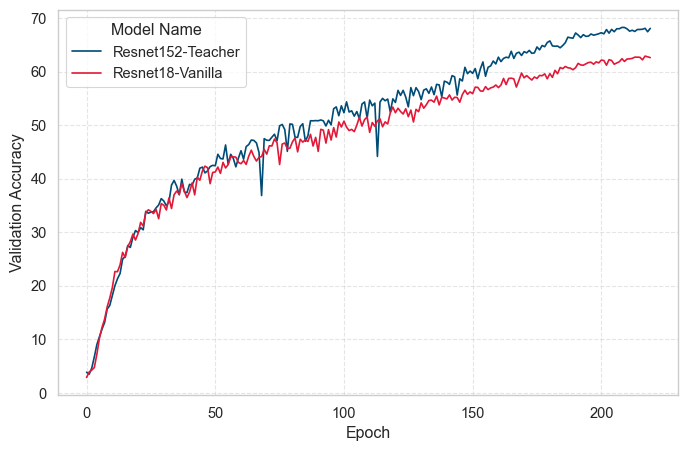

In [14]:
gratzer_style_sns()
teacher_and_vanilla.columns = ['Epoch','Validation Accuracy','Model Name']
sns.lineplot(data=teacher_and_vanilla,x='Epoch',y='Validation Accuracy',hue='Model Name')

plt.show()

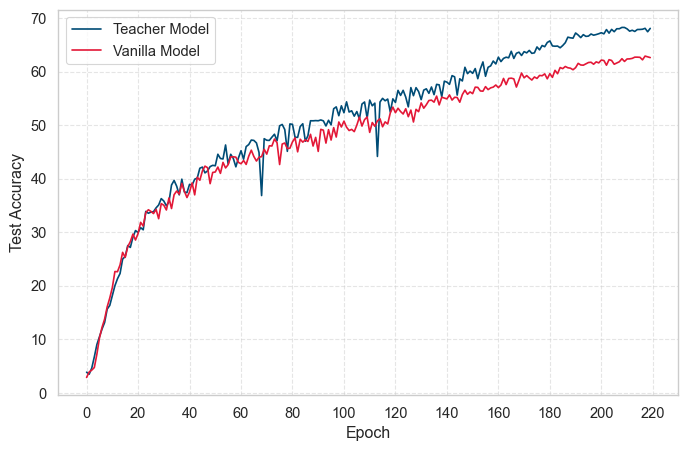

In [87]:
gratzer_style_sns()

plt.plot(np.arange(220),teacher_and_vanilla['Validation Accuracy'][:220],label = 'Teacher Model')
plt.plot(np.arange(220),teacher_and_vanilla['Validation Accuracy'][220:],label = 'Vanilla Model')

plt.xticks(np.arange(0, 221, 20))
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()

plt.savefig('teacher_vanilla_model.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
grouped_df = final_df.groupby(['_step', 'alpha', 'project'])['eval_top1'].mean().reset_index()

In [17]:
final_df_rd = grouped_df[grouped_df['project'] == "CIFAR-100-RD"]

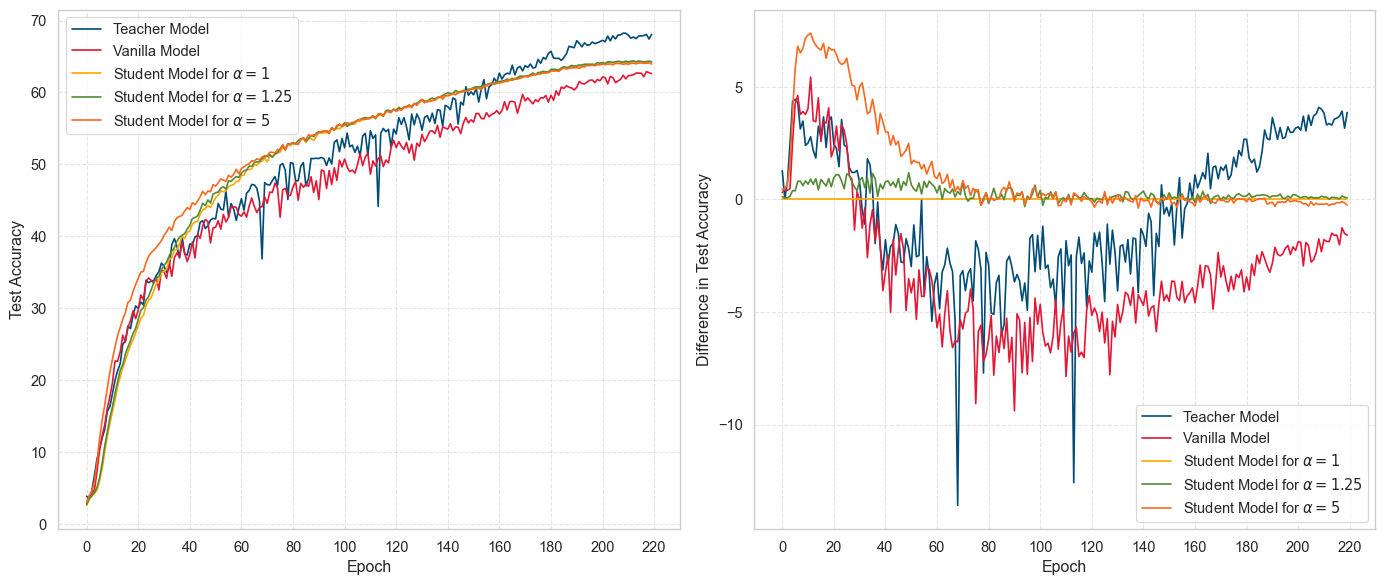

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

gratzer_style_sns()

ax1.plot(np.arange(220), teacher_and_vanilla['Validation Accuracy'][:220], label='Teacher Model')
ax1.plot(np.arange(220), teacher_and_vanilla['Validation Accuracy'][220:], label='Vanilla Model')
ax1.plot(np.arange(220), final_df_rd[final_df_rd["alpha"] == 1]['eval_top1'], label=r'Student Model for $\alpha = 1$')
ax1.plot(np.arange(220), final_df_rd[final_df_rd["alpha"] == 1.25]['eval_top1'], label=r'Student Model for $\alpha = 1.25$')
ax1.plot(np.arange(220), final_df_rd[final_df_rd["alpha"] == 5]['eval_top1'], label=r'Student Model for $\alpha = 5$')

ax1.set_xticks(np.arange(0, 221, 20))
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Test Accuracy')
ax1.legend()

diff = np.array(final_df_rd[final_df_rd["alpha"] == 1]['eval_top1'])

ax2.plot(np.arange(220), np.array(teacher_and_vanilla['Validation Accuracy'][:220]) - diff, label='Teacher Model')
ax2.plot(np.arange(220), np.array(teacher_and_vanilla['Validation Accuracy'][220:]) - diff, label='Vanilla Model')
ax2.plot(np.arange(220), diff - diff, label=r'Student Model for $\alpha = 1$')
ax2.plot(np.arange(220), np.array(final_df_rd[final_df_rd["alpha"] == 1.25]['eval_top1']) - diff, label=r'Student Model for $\alpha = 1.25$')
ax2.plot(np.arange(220), np.array(final_df_rd[final_df_rd["alpha"] == 5]['eval_top1']) - diff, label=r'Student Model for $\alpha = 5$')

ax2.set_xticks(np.arange(0, 221, 20))
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Difference in Test Accuracy')
ax2.legend()

# Adjust layout and save
plt.tight_layout()
plt.savefig('exp1_line_and_diff_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [21]:
filtered_df = final_df[final_df["alpha"].isin([0.5, 0.625, 0.75, 0.875, 1, 1.25, 1.5, 2, 3.5, 5, 7.5])]

In [22]:
filtered_df = final_df[final_df["project"]=="CIFAR-100-RD"]
filtered_df = filtered_df[-filtered_df["alpha"].isin([15])]

In [23]:
grouped_df = filtered_df.drop(columns=["project"]).groupby(["_step", "alpha"]).mean()

In [24]:
# Filter for project "CIFAR-100-RD" and selected _step values
selected_steps = [5, 10, 15, 20, 25, 50, 100, 219]
filtered_project_df = grouped_df.loc[grouped_df.index.get_level_values("_step").isin(selected_steps)]

# Pivot the table
table = filtered_project_df.reset_index().pivot(index="_step", columns="alpha")
#table = filtered_project_df.reset_index().pivot(index="alpha", columns="_step")

# Display the table
table

eval_top1                                                          \
alpha    0.050   0.100   0.250   0.500   0.625   0.750   0.875   1.000    
_step                                                                     
5         4.878   5.065   5.153   5.503   5.578   5.828   5.837   6.037   
10       13.261  13.311  13.553  14.134  14.598  14.970  15.139  15.643   
15       20.393  20.474  20.936  21.493  21.907  22.210  22.093  22.751   
20       24.832  24.831  25.304  25.819  26.226  26.632  27.089  27.521   
25       29.453  29.119  29.802  30.453  30.260  31.101  31.470  31.453   
50       43.612  43.411  43.925  44.604  44.607  44.989  45.408  45.406   
100      55.106  55.083  55.242  55.584  55.229  55.592  55.765  55.412   
219      64.107  63.953  64.063  64.067  64.072  64.062  64.086  64.200   

                                                                       
alpha  1.250   1.500   2.000   3.500   5.000   7.500   10.000  12.500  
_step                                                                  
5       6.413   6.913   7.990  11.395  11.845  10.210   8.493   7.066  
10     16.319  17.350  18.766  22.740  22.945  21.648  20.402  18.705  
15     23.633  24.248  26.472  29.650  29.382  28.568  27.111  25.939  
20     28.490  29.266  30.997  33.682  34.178  32.984  31.661  30.410  
25     32.587  33.390  34.892  37.513  37.724  36.533  35.499  33.911  
50     46.058  46.738  47.164  47.868  46.982  46.363  46.119  44.587  
100    55.819  55.699  56.208  56.358  55.501  54.832  53.921  54.062  
219    64.277  64.027  64.218  64.242  63.946  63.757  63.560  63.387

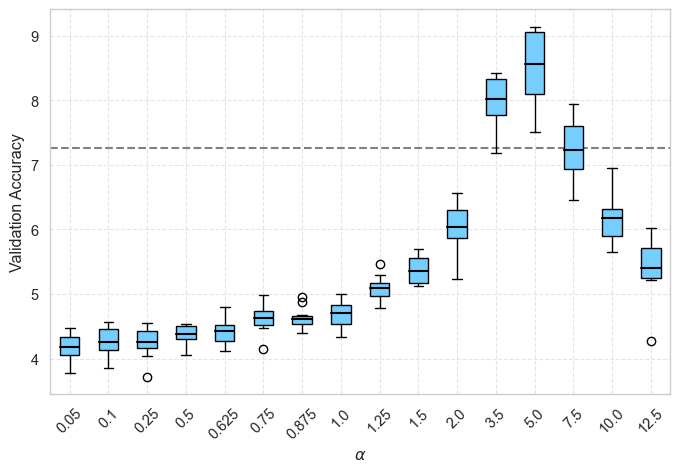

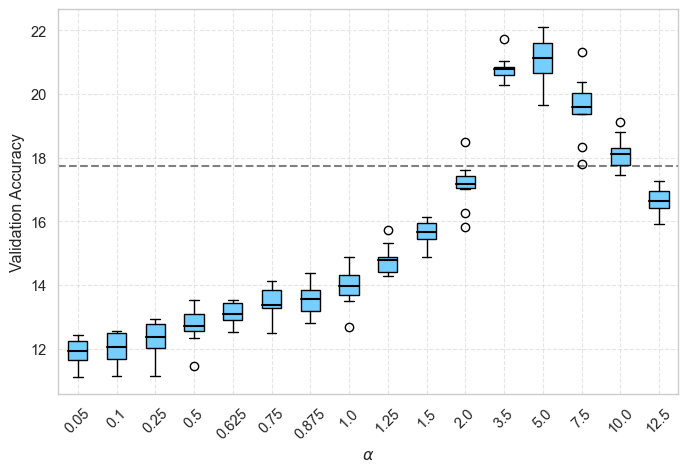

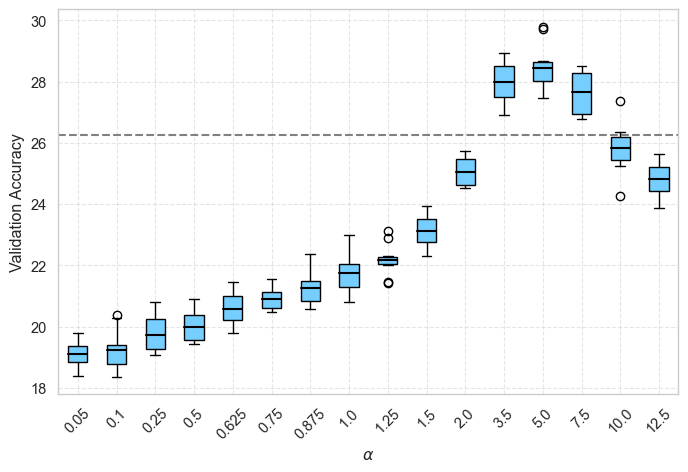

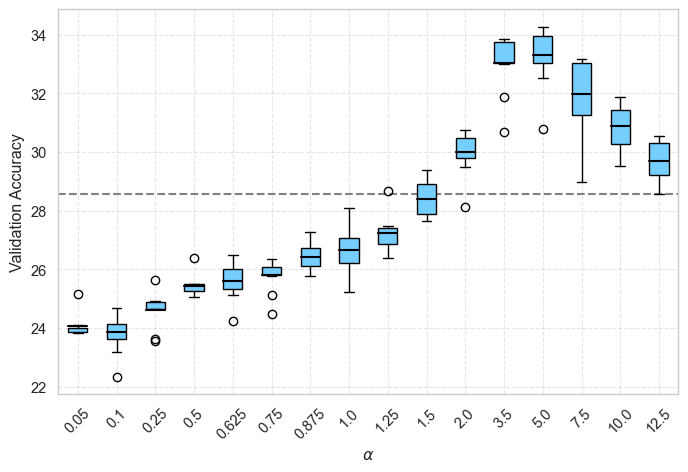

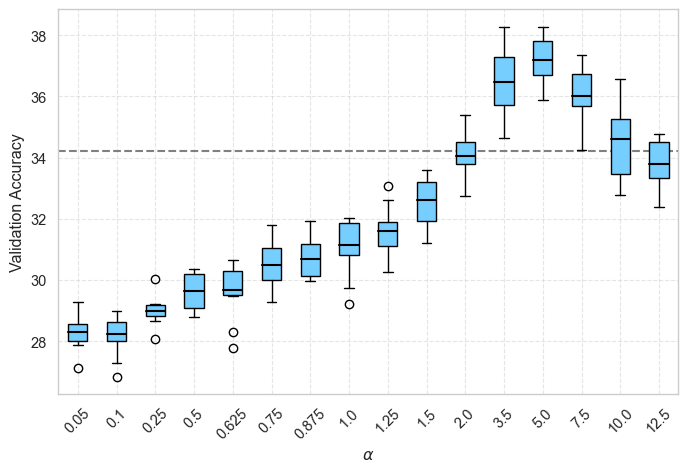

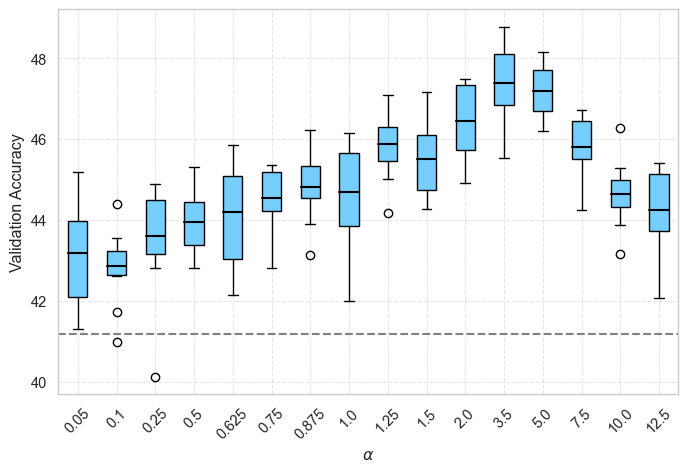

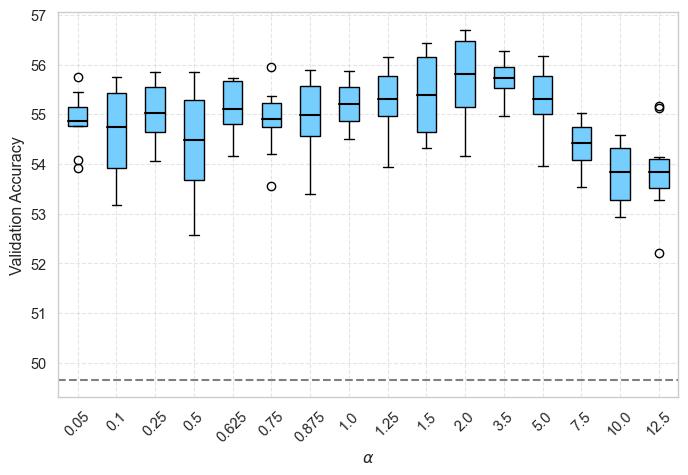

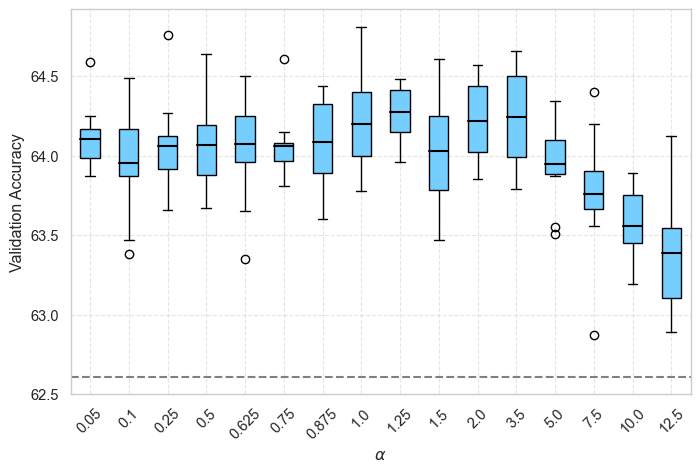

In [55]:
gratzer_lighter_style_sns()
step_values = [4, 9, 14, 19, 24, 49, 99, 219]

for step in step_values:
    df_filtered = filtered_df[filtered_df["_step"] == step]
    
    list_a = []
    alphas = np.unique(df_filtered['alpha'])
    for alpha in alphas:
        df_filtered_a = df_filtered[df_filtered['alpha'] == alpha]
        list_a.append(list(df_filtered_a['eval_top1']))
    
    fig, ax = plt.subplots()
    ax.set_ylabel('Validation Accuracy')

    ax.axhline(y=teacher_and_vanilla['Validation Accuracy'][220+step], color='gray', linestyle='--', linewidth=1.5)
    bplot = ax.boxplot(
        list_a,
        patch_artist=True,
        showmeans=True,
        meanline=True,
        meanprops={
            "color": "black",
            "linewidth": 1.5,
            "linestyle": "-"
        },
        medianprops={
            "linewidth": 0
        }
    )
    
    ax.set_xticklabels([f'{a}' for a in alphas], rotation=45)
    
    #plt.title(f"Boxplot for epoch {step}")
    plt.xlabel(r'$\alpha$')
    plt.ylabel("Validation Accuracy")
    plt.savefig(f'exp1_box_{step+1}.pdf', dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()

In [26]:
filtered_df_all_projects = final_df[final_df["alpha"].isin([0.5, 0.625, 0.75, 0.875, 1, 1.25, 1.5, 2, 3.5, 5, 7.5])]

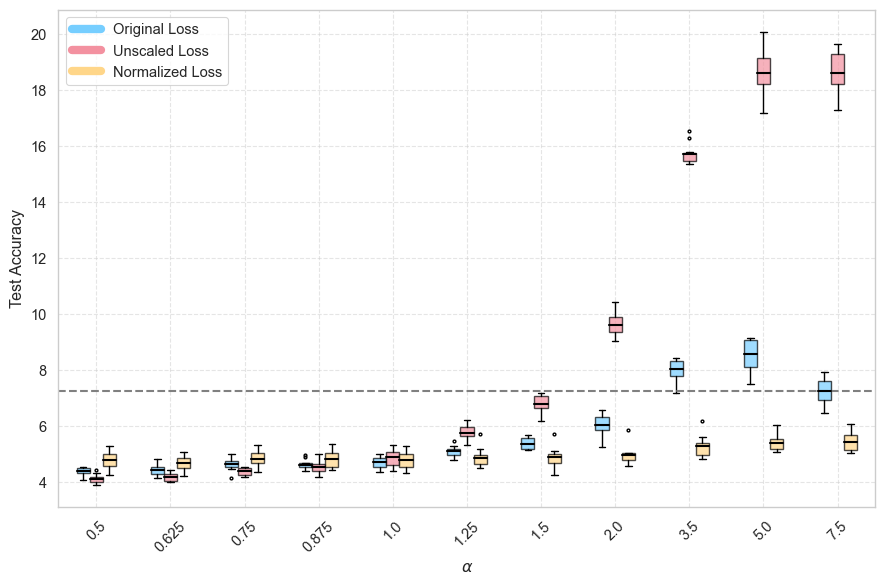

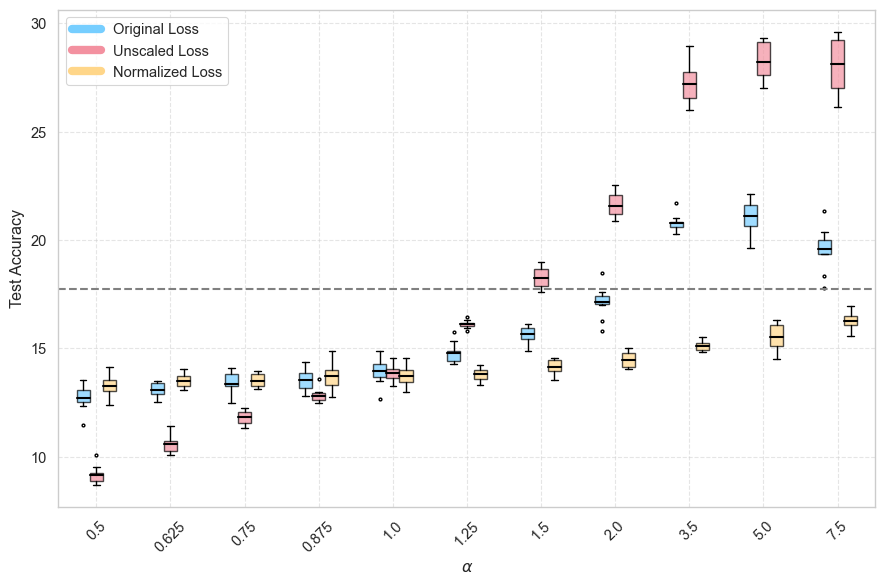

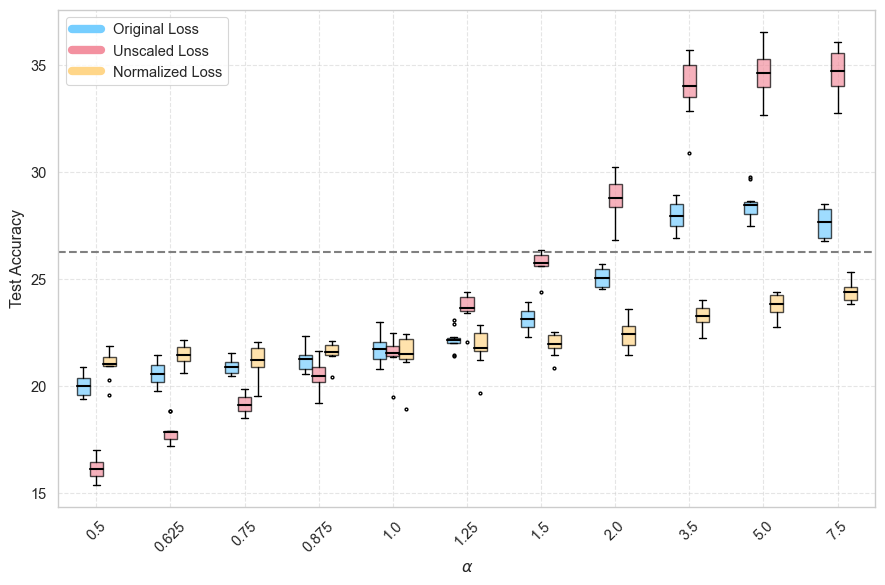

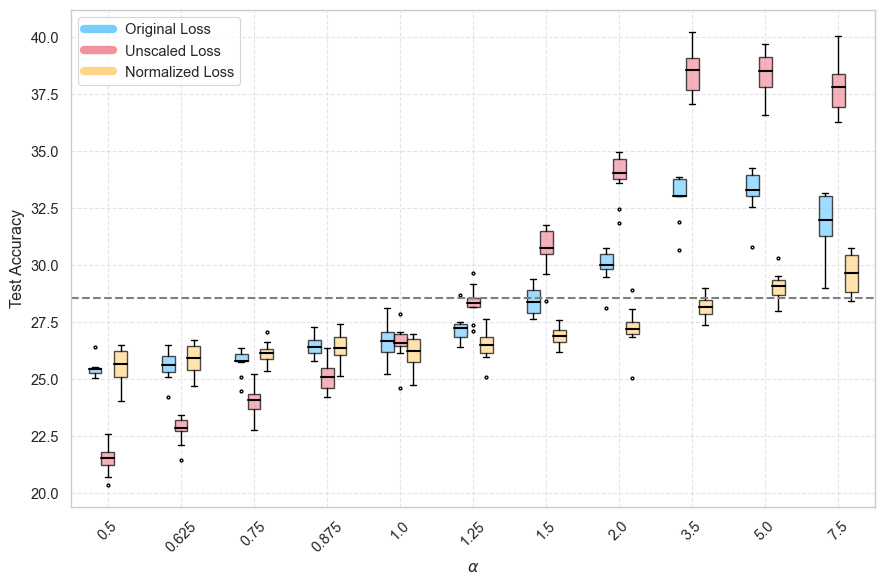

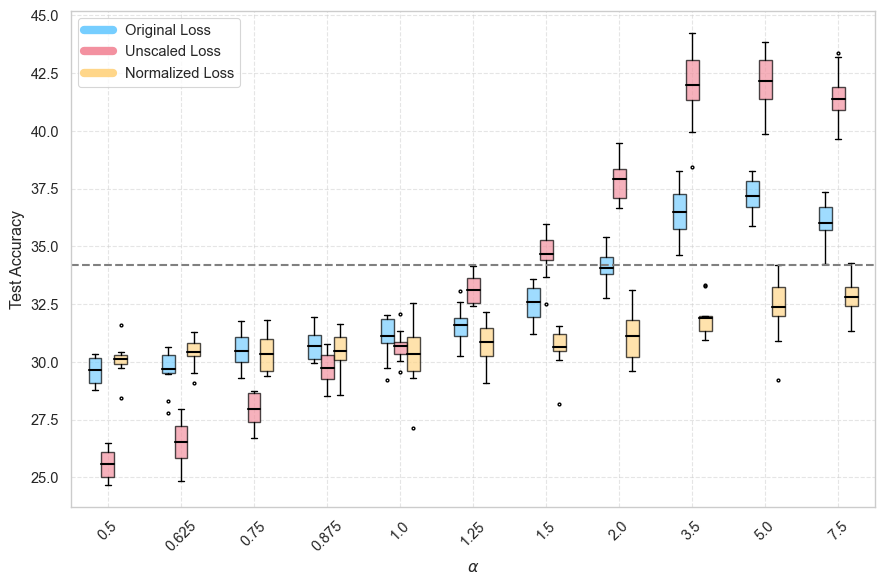

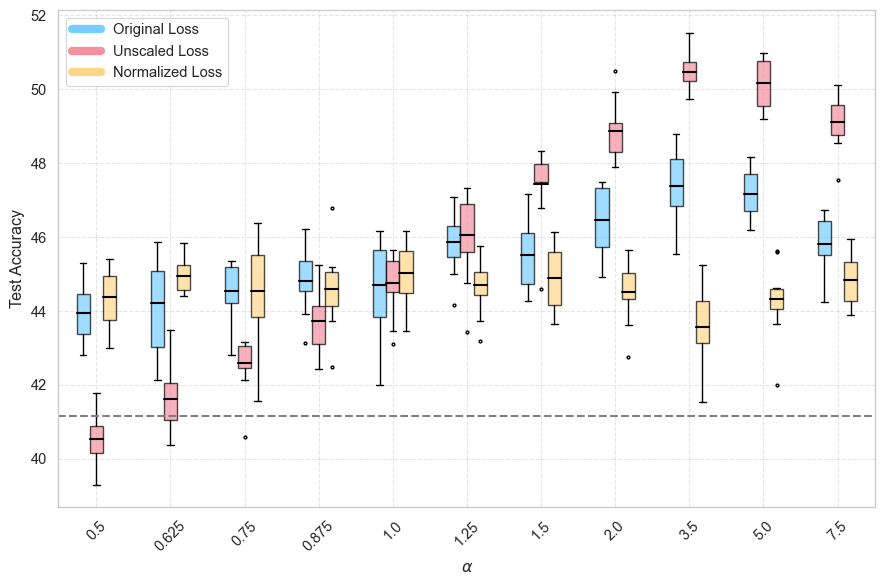

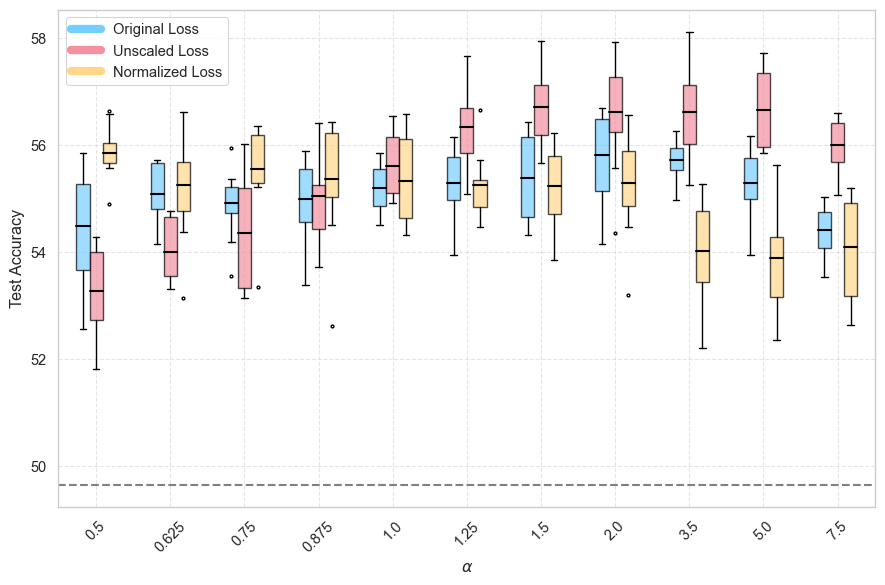

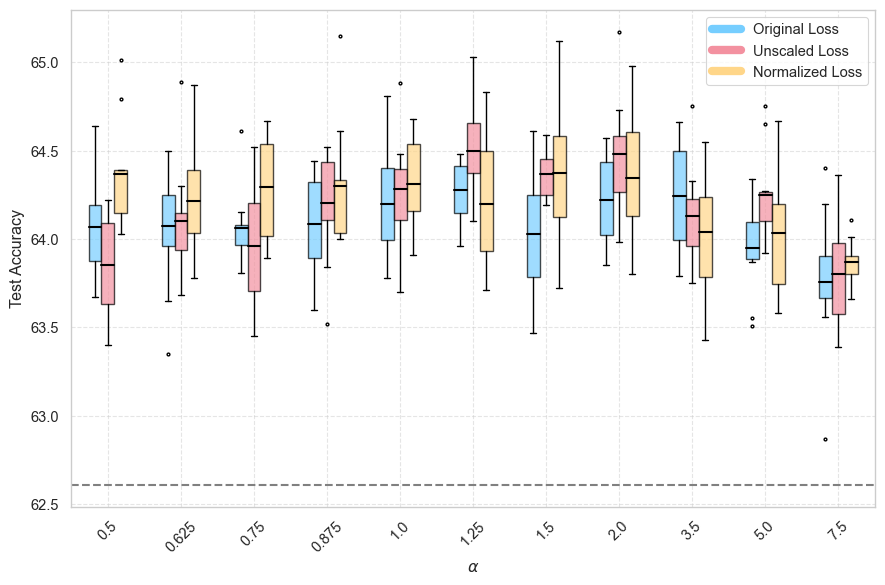

In [98]:
gratzer_lighter_style_sns()
step_values = [4, 9, 14, 19, 24, 49, 99, 219]

project_names = ['Original Loss','Unscaled Loss','Normalized Loss']
projects = ['CIFAR-100-RD', 'CIFAR-100-RD-NoAlpha','CIFAR-100-RD-Sigmoid-T4']
project_colors = ["#76ceff", "#f391a0", "#ffd689"]

for step in step_values:
    df_step = filtered_df_all_projects[filtered_df_all_projects["_step"] == step]
    alphas = np.sort(df_step['alpha'].unique())
    n_alphas = len(alphas)
    n_projects = len(projects)

    fig, ax = plt.subplots(figsize=(9, 6))
    ax.set_ylabel('Test Accuracy')

    width = 0.8  # total width of a group
    spacing = 1.5
    box_width = width / n_projects
    x_ticks = []

    for i, alpha in enumerate(alphas):
        center = i * spacing
        x_ticks.append(center)
        for j, project in enumerate(projects):
            df_ap = df_step[(df_step['alpha'] == alpha) & (df_step['project'] == project)]
            values = df_ap['eval_top1'].values

            if len(values) == 0:
                continue

            pos = center - width / 2 + j * box_width + box_width / 2
            ax.boxplot(
                [values],
                positions=[pos],
                patch_artist=True,
                widths=box_width,
                showmeans=True,
                meanline=True,
                meanprops={"color": "black", "linewidth": 1.5, "linestyle": "-"},
                medianprops={"linewidth": 0},
                boxprops={"facecolor": project_colors[j], "alpha": 0.7},
                flierprops={"markersize": 2},
                whiskerprops={"linewidth": 1},
                capprops={"linewidth": 1}
            )

    # Add horizontal line for vanilla model
    ax.axhline(y=teacher_and_vanilla['Validation Accuracy'][220 + step], color='gray', linestyle='--', linewidth=1.5)

    # Set x-ticks in the center of each alpha group
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f'{a}' for a in alphas], rotation=45)
    ax.set_xlabel(r'$\alpha$')

    # Add legend for projects
    handles = [plt.Line2D([0], [0], color=project_colors[i], lw=6) for i in range(n_projects)]
    ax.legend(handles, project_names, loc="best")

    plt.tight_layout()
    plt.savefig(f'exp2_box_grouped_{step + 1}.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [29]:
runs = api.runs(f"{ENTITY}/CIFAR-100-Alphas-Students")
all_histories = []
for run in runs:
    history = run.history(keys=["xy_T2", "_step"], pandas=True)
    alpha = run.config.get("alpha", None)
    history['alpha'] = alpha
    all_histories.append(history)
    
preliminary_xy_T2 = pd.concat(all_histories, ignore_index=True)

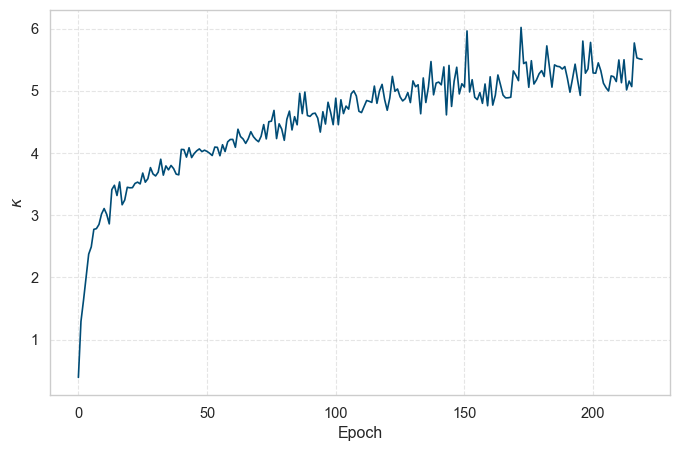

In [96]:
gratzer_style_sns()
preliminary_group_by = preliminary_xy_T2.groupby(["_step"]).mean()['xy_T2'][:219]

plt.plot(np.arange(220),preliminary_group_by)

plt.xlabel("Epoch")
plt.ylabel(r'$\kappa$')
plt.savefig(f'xy_T2.pdf', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

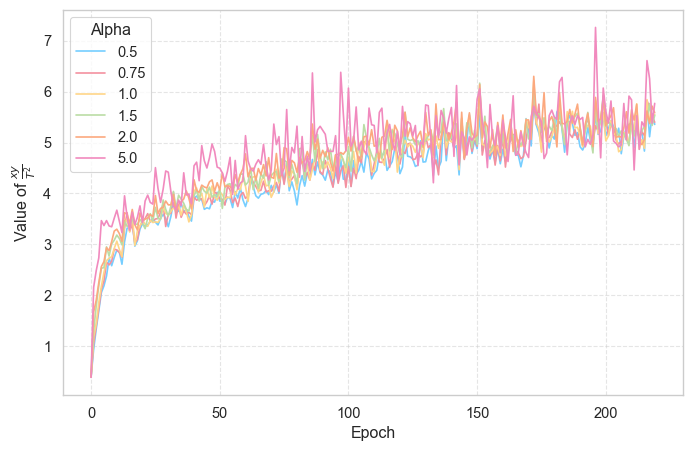

In [31]:
preliminary_group_by_alpha = preliminary_xy_T2.groupby(["_step","alpha"]).mean()

for alpha in np.unique(preliminary_xy_T2['alpha']):
    plt.plot(np.arange(220),preliminary_xy_T2[preliminary_xy_T2["alpha"] == alpha].groupby(["_step"]).mean()['xy_T2'][:219],label=alpha)
    
plt.legend(title='Alpha')
plt.xlabel("Epoch")
plt.ylabel(r'Value of $\frac{xy}{T^2}$')
plt.savefig(f'xy_T2_alphas.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()   

In [75]:
df_noalpha = filtered_df_all_projects[filtered_df_all_projects["project"]=="CIFAR-100-RD-NoAlpha"].groupby(["_step","alpha","project"]).mean().reset_index()
df_sigmoid = filtered_df_all_projects[filtered_df_all_projects["project"]=="CIFAR-100-RD-Sigmoid-T4"].groupby(["_step","alpha","project"]).mean().reset_index()

In [67]:
final_df_rd

,_step,alpha,project,eval_top1
0,0,0.050,CIFAR-100-RD,2.344
2,0,0.100,CIFAR-100-RD,2.407
3,0,0.250,CIFAR-100-RD,2.429
4,0,0.500,CIFAR-100-RD,2.454
7,0,0.625,CIFAR-100-RD,2.515
...,...,...,...,...
8791,219,5.000,CIFAR-100-RD,63.946
8794,219,7.500,CIFAR-100-RD,63.757
8797,219,10.000,CIFAR-100-RD,63.560
8798,219,12.500,CIFAR-100-RD,63.387


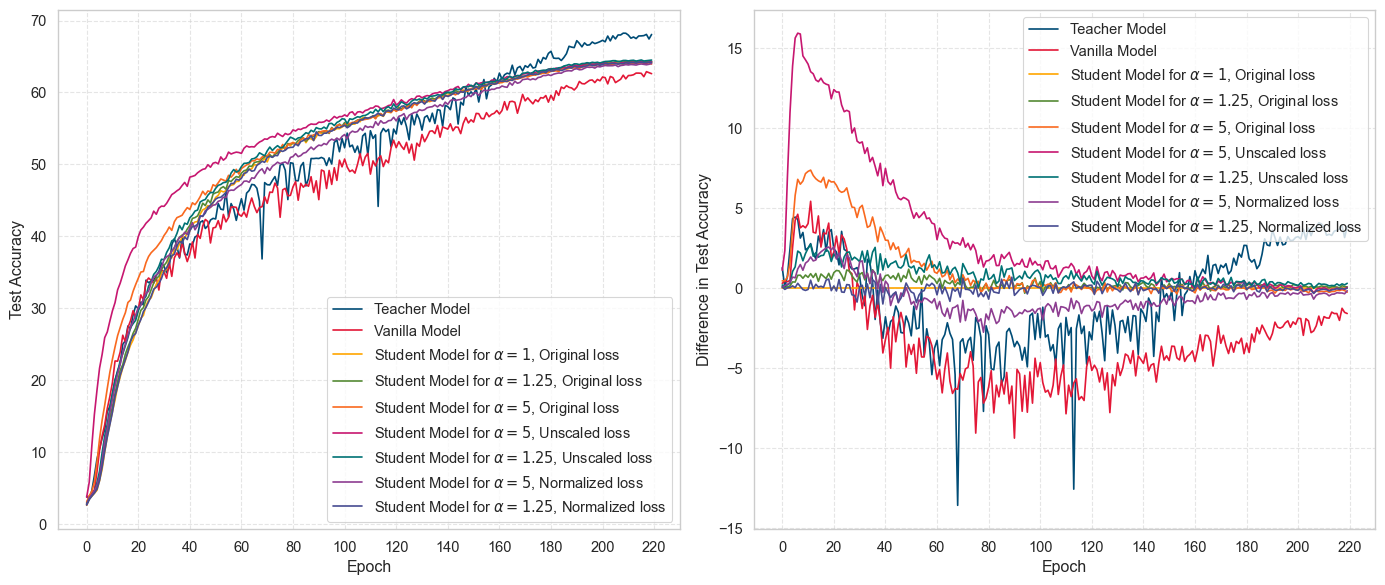

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

gratzer_style_sns()

ax1.plot(np.arange(220), teacher_and_vanilla['Validation Accuracy'][:220], label='Teacher Model')
ax1.plot(np.arange(220), teacher_and_vanilla['Validation Accuracy'][220:], label='Vanilla Model')
ax1.plot(np.arange(220), final_df_rd[final_df_rd["alpha"] == 1]['eval_top1'], label=r'Student Model for $\alpha = 1$, Original loss')
ax1.plot(np.arange(220), final_df_rd[final_df_rd["alpha"] == 1.25]['eval_top1'], label=r'Student Model for $\alpha = 1.25$, Original loss')
ax1.plot(np.arange(220), final_df_rd[final_df_rd["alpha"] == 5]['eval_top1'], label=r'Student Model for $\alpha = 5$, Original loss')

ax1.plot(np.arange(220), df_noalpha[df_noalpha["alpha"] == 5]['eval_top1'], label=r'Student Model for $\alpha = 5$, Unscaled loss')
ax1.plot(np.arange(220), df_noalpha[df_noalpha["alpha"] == 1.25]['eval_top1'], label=r'Student Model for $\alpha = 1.25$, Unscaled loss')

ax1.plot(np.arange(220), df_sigmoid[df_sigmoid["alpha"] == 5]['eval_top1'], label=r'Student Model for $\alpha = 5$, Normalized loss')
ax1.plot(np.arange(220), df_sigmoid[df_sigmoid["alpha"] == 1.25]['eval_top1'], label=r'Student Model for $\alpha = 1.25$, Normalized loss')



ax1.set_xticks(np.arange(0, 221, 20))
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Test Accuracy')
ax1.legend()

diff = np.array(final_df_rd[final_df_rd["alpha"] == 1]['eval_top1'])

ax2.plot(np.arange(220), np.array(teacher_and_vanilla['Validation Accuracy'][:220]) - diff, label='Teacher Model')
ax2.plot(np.arange(220), np.array(teacher_and_vanilla['Validation Accuracy'][220:]) - diff, label='Vanilla Model')
ax2.plot(np.arange(220), diff - diff, label=r'Student Model for $\alpha = 1$, Original loss')
ax2.plot(np.arange(220), np.array(final_df_rd[final_df_rd["alpha"] == 1.25]['eval_top1']) - diff, label=r'Student Model for $\alpha = 1.25$, Original loss')
ax2.plot(np.arange(220), np.array(final_df_rd[final_df_rd["alpha"] == 5]['eval_top1']) - diff, label=r'Student Model for $\alpha = 5$, Original loss')

ax2.plot(np.arange(220), np.array(df_noalpha[df_noalpha["alpha"] == 5]['eval_top1']) - diff, label=r'Student Model for $\alpha = 5$, Unscaled loss')
ax2.plot(np.arange(220), np.array(df_noalpha[df_noalpha["alpha"] == 1.25]['eval_top1']) - diff, label=r'Student Model for $\alpha = 1.25$, Unscaled loss')

ax2.plot(np.arange(220), np.array(df_sigmoid[df_sigmoid["alpha"] == 5]['eval_top1']) - diff, label=r'Student Model for $\alpha = 5$, Normalized loss')
ax2.plot(np.arange(220), np.array(df_sigmoid[df_sigmoid["alpha"] == 1.25]['eval_top1']) - diff, label=r'Student Model for $\alpha = 1.25$, Normalized loss')

ax2.set_xticks(np.arange(0, 221, 20))
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Difference in Test Accuracy')
ax2.legend(loc='upper right')

# Adjust layout and save
plt.tight_layout()
plt.savefig('exp2_line_and_diff_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()